# Image Classification Challenge

In [7]:
##################################################
# Imports
##################################################

import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

##################################################
# Params
##################################################

#write path to your local folder where data are stored
#os.chdir(r'C:\Users\Vittorino\Google Drive\Data Science - Unipd\I Year\II Semester\Algorithmic Methods and Machine Learning\Machine Learning\Project2\data')
currentDirectory=os.getcwd()#current working directory

DATA_BASE_FOLDER = 'data'

# Dataset

The dataset contains 50k train + 10k validation images of 10 different categories ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot').

Each image is a 28x28 grayscale, and for simplicity here is flattened into a 784 dimensional vector.

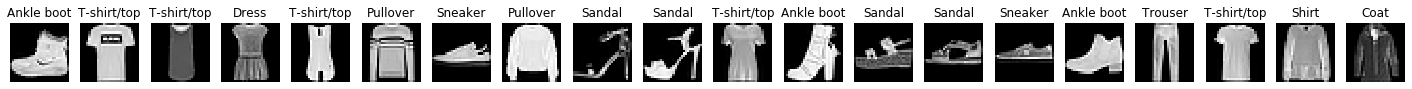

In [8]:
##################################################
# Load dataset
##################################################

x_train = np.load(os.path.join(DATA_BASE_FOLDER, 'train.npy'))
x_valid = np.load(os.path.join(DATA_BASE_FOLDER, 'validation.npy'))
x_test = np.load(os.path.join(DATA_BASE_FOLDER, 'test.npy'))
y_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))['class'].values
y_valid = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))['class'].values
y_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot random images of different classes
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = x_train[idx].reshape(28, 28)
    plt.title(f'{y_labels[y_train[idx]]}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [9]:
x_train.shape

(50000, 784)

# Overview

We are going to apply four different models:
- Logistic Regression
- KNN
- Random Forest
- Support Vector Machines
- Convolutional Neural Networks

For each of them we apply the needed pre-processing of data and evaluate their performances.

# Model - Logistic Regression

### Pre-processing
Since we are going to apply regularization, it's advisible to standardize data. 

In order to fit the data in a reasonable amount of time, we take 20% of observation in the train set to train the model.


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled=scaler.transform(x_test)

In [9]:
x_train_reduced=x_train_scaled[0:10000]
y_train_reduced=y_train_scaled[0:10000]

### Model estimation

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
# Define the grid for the grid search
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]#inverse of regularization parameter = 1/lambda
solver = ['liblinear', 'saga']#the only two solver which support both l1 and l2 regularization
param_grid = dict(penalty=penalty,
                  C=C,
                  solver=solver)
# Cross Validation strategy
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
print(param_grid)

{'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'saga']}


In [ ]:
##################################################
# Implement you model here
##################################################

logreg = LogisticRegression()
# grid search con 5 fold cross validation
grid_search = GridSearchCV(estimator=logreg,
                            param_grid=param_grid,
                            cv=cv,
                            n_jobs=-1)
grid_search.fit(x_train_reduced, y_train_reduced)

print(grid_search.best_params_)
print("Cross Validation Accuracy: %f" % grid_search.best_score_)

In [ ]:
# save the model to disk
filename = 'grid_search_Logistic.sav'
joblib.dump(grid_search, filename)

In [12]:
# to load the model from disk
filename = 'grid_search_Logistic.sav'
grid_search = joblib.load(filename)

In [13]:
# optimal hyperparameters
grid_search.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'saga'}

In [14]:
#Performance in validation set of the optimal model 
grid_search.best_score_

0.8411

In [11]:
#performance in the test set of the optimal model trained in a subset of full train set
grid_search.score(x_valid_scaled, y_valid)

0.841

In [15]:
results_grid_search_logistic = pd.DataFrame(grid_search.cv_results_)
results_grid_search_logistic=results_grid_search_logistic[['params','mean_test_score','rank_test_score']]
results_grid_search_logistic

,params,mean_test_score,rank_test_score
0,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.0942,32
1,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'saga'}",0.1026,31
2,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.7431,28
3,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'saga'}",0.7692,24
4,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.3854,29
5,"{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}",0.3780,30
6,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.7985,18
7,"{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}",0.8268,13
8,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.7835,22
9,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.7869,20


In [17]:
#If the .sav file is too big to be shared with professor, we could save the dataFrame as a .csv
#and share only it.
results_grid_search_logistic.to_csv('results_grid_search_logistic.csv', sep=',',index=False)

#read the model
pd.read_csv('results_grid_search_logistic.csv')

,params,mean_test_score,rank_test_score
0,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.0942,32
1,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'saga'}",0.1026,31
2,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.7431,28
3,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'saga'}",0.7692,24
4,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.3854,29
5,"{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}",0.3780,30
6,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.7985,18
7,"{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}",0.8268,13
8,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.7835,22
9,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.7869,20


### Train the model with the optimal hyperparameters on the full Training Set
Train the model with optimal hyperparameters found in the reduced training set, on the full train set.

In [22]:
logreg = LogisticRegression(penalty='l2',#ridge regularization
                            C=1,
                            solver='saga',
                            max_iter=1000)
logreg.fit(x_train_scaled,y_train)

C:\Users\Vittorino\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

### Model evaluation

In [24]:
logreg.score(x_valid_scaled, y_valid)

0.8492

In [23]:
# save the model to disk
filename = 'LogisticRegr.sav'
joblib.dump(logreg, filename)

['LogisticRegr.sav']

In [20]:
# to load the model from disk
filename = 'LogisticRegr.sav'
logreg=joblib.load(filename)

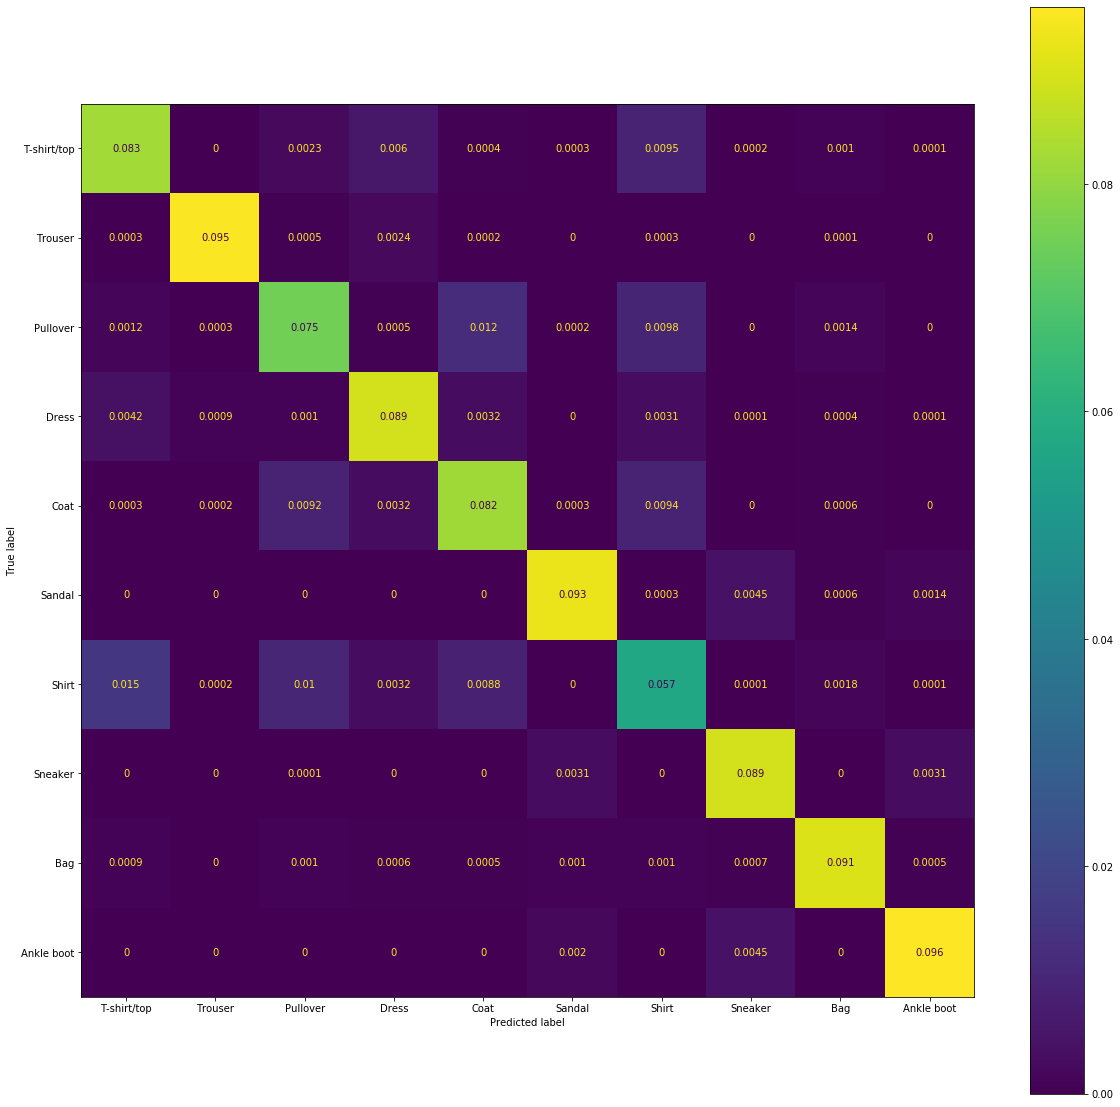

In [25]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(logreg, x_valid_scaled, y_valid,
                                     normalize='true', 
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown label in the test set: 

In [ ]:
y_pred_logreg=logreg.predict(x_test_scaled)

In [ ]:
# save that on a .csv file for the submission
predictions_logreg_file = y_pred_logreg.to_csv('y_predictions_logreg.csv', sep=',',index=False)

# Model - KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

### Pre-processing
For better numerical stability is advisible to divide by 255 each feature.


In [11]:
x_train_norm=x_train/255
x_valid_norm=x_valid/255
x_test_norm=x_test/255

### Model estimation
We use grid search to find the best value of k (='n_neighbors'). 

We do not look for the best value of $p$ in the $L_p$ metrics, because theorical 
results have prooved that the meaningfulness of the $L_p$ norm worsens faster within 
increasing dimensionality for higher values of $p$. Thus, for a given problem with a 
fixed (high) value for the dimensionality $d$, it is preferable to use lower values of $p$.
This means that the $L_1$ distance metric (Manhattan distance metric) is the most preferable 
for high dimensional applications, followed by the Euclidean metric ($L_2$).  
For reference see:

- Charu C. Aggarwal, Alexander Hinneburg, Daniel A. Keim, "On the Surprising Behavior of    Distance Metrics in High Dimensional Space"
- Kevin Beyer, Jonathan Goldstein, Raghu Ramakrishnan, Uri Shaft, "When Is 'Nearest Neighbor' Meaningful?"

In [ ]:
# Define the grid for the grid search
param_grid = {'n_neighbors': list(range(1,21))}
# Cross Validation strategy
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
print(param_grid)

In [ ]:
##################################################
# Implement you model here
##################################################
knn = KNeighborsClassifier()
# grid search with 5 fold cross validation
grid_search = GridSearchCV(KNeighborsClassifier(p=1),
                           param_grid, 
                           cv=cv,
                           n_jobs=-1)
grid_search.fit(x_train_norm, y_train)
print(grid_search.best_params_)
print("Cross Validation Accuracy: %f" % grid_search.best_score_)

In [ ]:
# save the model to disk
filename = 'grid_search_knn.sav'
joblib.dump(grid_search, filename)

In [26]:
# to load the model from disk
filename = 'grid_search_knn.sav'
grid_search = joblib.load(filename)

In [27]:
# optimal hyperparameters
grid_search.best_params_

{'n_neighbors': 5}

In [28]:
#Performance in validation set of the optimal model 
grid_search.best_score_

0.85958

In [31]:
#performance in the test set of the optimal model trained in the full train set
grid_search.score(x_valid_norm, y_valid)

0.857

## Test with Euclidean Distance
To check if the Manhattan metric yields better results than the Euclidean we make the same grid search using the L2 metric. 

In [ ]:
# STRATIFIED KFOLD + GRID SEARCH (EUCLIDEAN METRIC (L2))
# use grid search to find the best value of k

# with p=2 we are using the euclidean Distance (default parameter)
grid_search_euclidean = GridSearchCV(
    KNeighborsClassifier(p=2), param_grid, cv=cv, n_jobs=-1)
grid_search_euclidean.fit(x_train_norm, y_train)

In [ ]:
# save the model to disk
joblib.dump(grid_search_euclidean, "grid_search_knn_euclidean.sav")

In [12]:
# to load the trained model from disk
filename = '../ml aux/models/grid_search_knn_euclidean.sav'
grid_search_euclidean = joblib.load(filename)

In [13]:
# PRINT EUCLIDEAN MODEL PERFORMANCE
print("Best parameters: {}".format(grid_search_euclidean.best_params_))
print(\
    "Best cross-validation score: {:.2f}".format(grid_search_euclidean.best_score_))

Best parameters: {'n_neighbors': 6}
Best cross-validation score: 0.85


In [14]:
#performance in the test set of the optimal model trained in the full train set
grid_search_euclidean.score(x_valid_norm, y_valid)

0.8547

### Dimensionaly reduction using PCA
To recognize an item, we don't look at the single pixel, but at the overall image.
So extracting Principal Components (PCs) and using them to identify different items 
is an attempt to mimic how humans identify items.
Using the optimal value of $k$ found before, we look how much varies the accuracy
in train and valid set increasing the n° of PCs used to approximate each sample.
Around 20 PCs, the Accuracy curve starts being flat, meaning that adding further 
PCs increases just a little the performance, so it's not worth to add them.

In [38]:
from sklearn.decomposition import PCA

In [ ]:
test_accuracy = []
PC_number = range(1, 101)
for i in PC_number:
    pca = PCA(n_components=i, whiten=True, random_state=0).fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_valid_pca = pca.transform(x_valid)
    knn = KNeighborsClassifier(n_neighbors=k_star,p=1)
    knn.fit(x_train_pca, y_train)
    # record generalization accuracy
    test_accuracy.append(knn.score(x_valid_pca, y_valid.reshape(-1,1)))

plt.plot(PC_number, test_accuracy, label="valid accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n° PC")
plt.legend()  

In [ ]:
#save the figure
plt.savefig('Accuracy VS number_PCs.png')

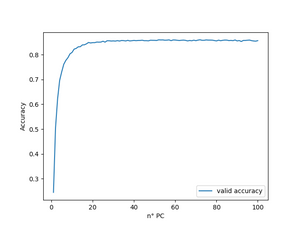

In [32]:
#load the figure
import matplotlib.image as mpimg
img = mpimg.imread('Accuracy VS number_PCs.png')
plt.axis('off')
plt.imshow(img,interpolation='spline36')

Observing the plot, the accuracy growth becomes flat approx. after the first 20 PCs. 
So to have an easier model, with less features, we decide to use 20 PCs.

In [33]:
PCs_star=20

We compute the first 20 PCs for train set and validation set.

In [39]:
pca = PCA(n_components=20, whiten=True, random_state=0).fit(x_train_norm)
x_train_pca = pca.transform(x_train_norm)
x_valid_pca = pca.transform(x_valid_norm)
x_test_pca = pca.transform(x_test_norm)

In [ ]:
# save the model to disk
filename = 'pca.sav'
joblib.dump(pca, filename)

In [34]:
# to load the model from disk
filename = 'pca.sav'
pca = joblib.load(filename)

We train the model with the optimal hyperparameter $k^*=5$ on the full training set.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)
knn.fit(x_train_pca, y_train)

In [ ]:
# save the model to disk
filename = '5nn.sav'
joblib.dump(knn, filename)

In [35]:
# to load the model from disk
filename = '5nn.sav'
knn = joblib.load(filename)

In [ ]:
#plot the PCs
print("pca.components_.shape: {}".format(pca.components_.shape))
fix, axes = plt.subplots(4, 5, figsize=(15, 12),subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape((28,28)),cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))
plt.savefig('first 20 PCs.png')

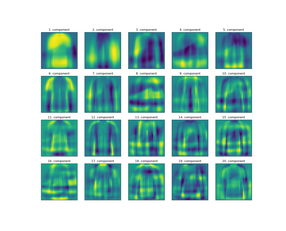

In [41]:
#load the figure
img = mpimg.imread('first 20 PCs.png')
plt.axis('off')
plt.imshow(img,interpolation='spline36')

### Model evaluation

The perfomance in the validation set is:

In [43]:
knn.score(x_valid_pca, y_valid.reshape(-1,1))

0.8482

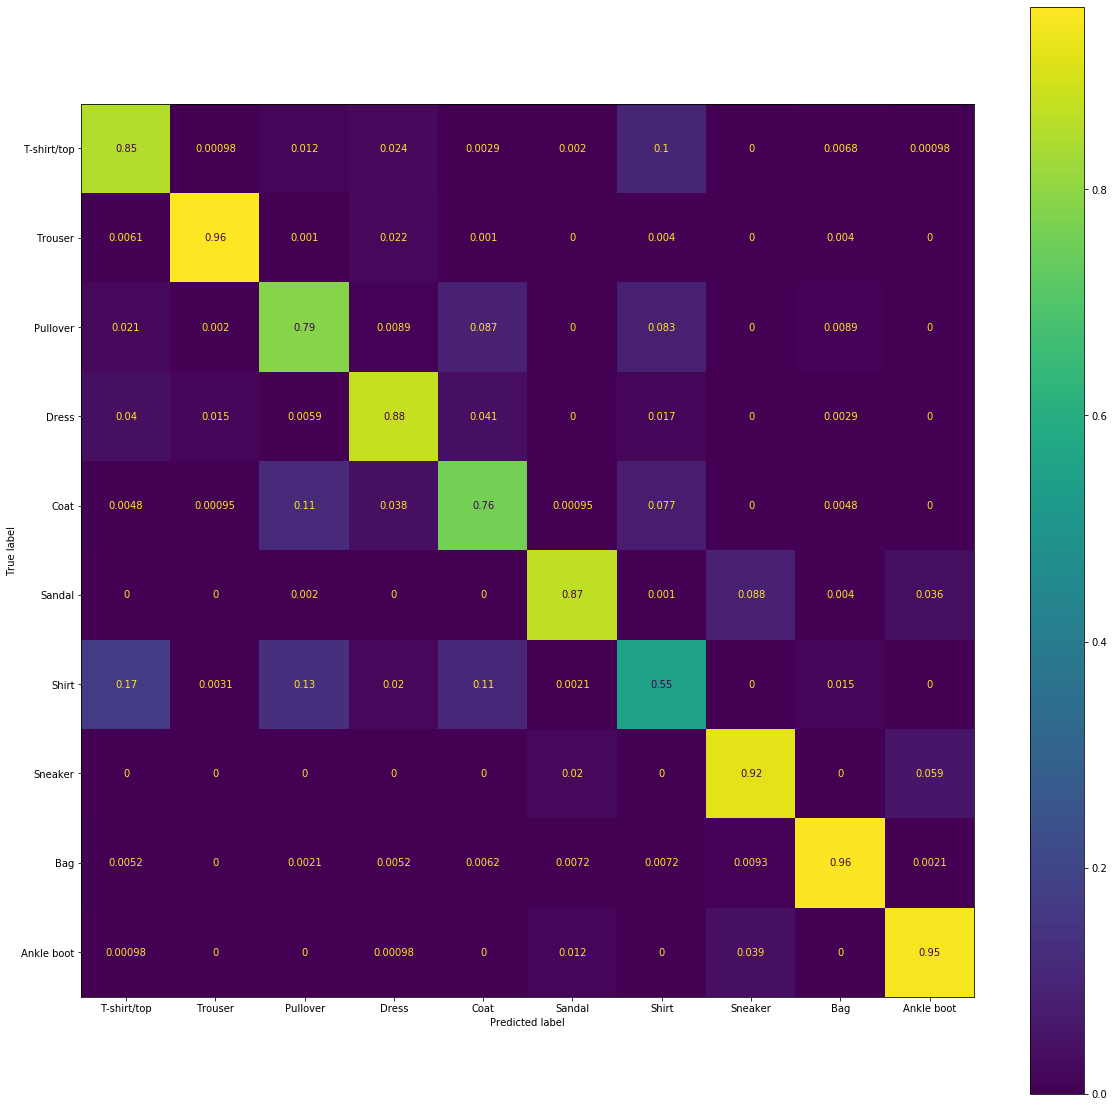

In [46]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(knn, x_valid_pca, y_valid,
                                     normalize='true', 
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown labels in the test set: 

In [ ]:
y_pred_knn=knn.predict(x_test_pca)

In [ ]:
# save that on a .csv file for the submission
predictions_knn_file = y_pred_knn.to_csv('y_predictions_knn.csv', sep=',',index=False)

# Model - Random Forest

### Pre-processing

In [ ]:
x_train_norm=x_train/255
x_valid_norm=x_valid/255
x_test_norm=x_test/255

pca = PCA(n_components=20, whiten=True, random_state=0).fit(x_train_norm)
x_train_pca = pca.transform(x_train_norm)
x_valid_pca = pca.transform(x_valid_norm)
x_test_pca = pca.transform(x_test_norm)

### Model estimation
Using PCA, we reduced the features' dimension from 784 to 20. Now, we want to apply
a 'Decision Tree' to classify the items using only the 20 PCs extracted before.

Choosing the parameter 'max_depth' high enough, it's possible to classify 
perfectly each class in the training set, reaching an accuracy of 100%. But
then the performance in the test set is going to be much smaller, due to overfitting.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
tree = DecisionTreeClassifier(max_depth=15,random_state=0)
tree.fit(x_train_pca, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(x_train_pca, y_train)))
print("Accuracy on validation set: {:.3f}".format(tree.score(x_valid_pca, y_valid)))

A random forest is essentially a collection of decision trees, where each tree is slightly different from the others. The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amount
of overfitting by averaging their results. 

**Important Note**: we are aware that, by using this kind of model over the features extracted via PCA, we are losing a very important advantage that Random Forest gives, which is the **interpretability** of the results (the principal components, are not features that we can interpret in a meaningful and intuitive way). Anyhow, we wanted to see how this kind of decision tree based model could perform on such a setting.

- 'n_estimators': number of trees to build(larger is always better. Averaging more trees will yield a more robust ensemble by reducing overfitting.)
- 'max_features': number of randomly selected features among which the algo looks for the best one. Tt’s a good rule of thumb to use the default values: max_features=$\sqrt{n_{features}}$

In [ ]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=15,
                                max_features=5, 
                                random_state=0,
                                n_jobs=-1)
forest.fit(x_train_pca, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(x_train_pca, y_train)))
print("Accuracy on valid set: {:.3f}".format(forest.score(x_valid_pca, y_valid)))

We use the grid search technique to find the best values of hyperparameters:
- 'max_depth'
- 'max_features'

In [ ]:
# Define the grid for the grid search
param_grid = {'max_depth': list(range(1,21)),
              'max_features': list(range(1,21))}
# Cross Validation strategy
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(n_estimators=100,
                                                  random_state=0,
                                                  n_jobs=-1),
                           param_grid, cv=cv,n_jobs=-1)
grid_search.fit(x_train_pca, y_train)

In [ ]:
# save the model to disk
filename = 'grid_search_forest.sav'
joblib.dump(grid_search, filename)

In [ ]:
# to load the model from disk
filename = 'grid_search_forest.sav'
grid_search = joblib.load(filename)

In [ ]:
# convert the grid_search model in a dataframe to see easely the results
results_grid_search_randForest = pd.DataFrame(grid_search.cv_results_)
results_grid_search_randForest=results[['params','mean_test_score','rank_test_score']]

In [ ]:
print("Best parameters: {}".format(grid_search.best_params_))

There is a problem: the optimal hyperparamer 'max_depth' $=20$ is a corner solution.
To be sure that does not exist a better model with higher depth, we expand
the grid search to values of 'max_depth' $\ge20$.

In [ ]:
param_grid = {'max_depth': list(range(20,30)),
              'max_features': list(range(5,11))}
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
grid_search = GridSearchCV(RandomForestClassifier(n_estimators=100,
                                                  random_state=0,
                                                  n_jobs=-1),
                           param_grid, cv=cv,n_jobs=-1)
grid_search.fit(x_train_pca, y_train)

In [ ]:
# save the model to disk
filename = 'grid_search_restricted_forest.sav'
joblib.dump(grid_search, filename)

In [47]:
# to load the model from disk
filename = 'grid_search_restricted_forest.sav'
grid_search = joblib.load(filename)

In [50]:
# convert the grid_search model in a dataframe to see easely the results
results_grid_search_randForest = pd.DataFrame(grid_search.cv_results_)
results_grid_search_randForest=results_grid_search_randForest[['params','mean_test_score','rank_test_score']]
results_grid_search_randForest.head()

,params,mean_test_score,rank_test_score
0,"{'max_depth': 20, 'max_features': 5}",0.85376,52
1,"{'max_depth': 20, 'max_features': 6}",0.85472,29
2,"{'max_depth': 20, 'max_features': 7}",0.85394,51
3,"{'max_depth': 20, 'max_features': 8}",0.85316,58
4,"{'max_depth': 20, 'max_features': 9}",0.85254,60


In [51]:
print("Best parameters: {}".format(grid_search.best_params_))

Best parameters: {'max_depth': 24, 'max_features': 7}


We train the model with optimal hyperparameters:

In [54]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=24,
                                max_features=7, 
                                random_state=0,
                                n_jobs=-1)
forest.fit(x_train_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=24, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Model evaluation

In [55]:
print("Validation set score: {:.3f}".format(grid_search.score(x_valid_pca, y_valid)))

Validation set score: 0.851


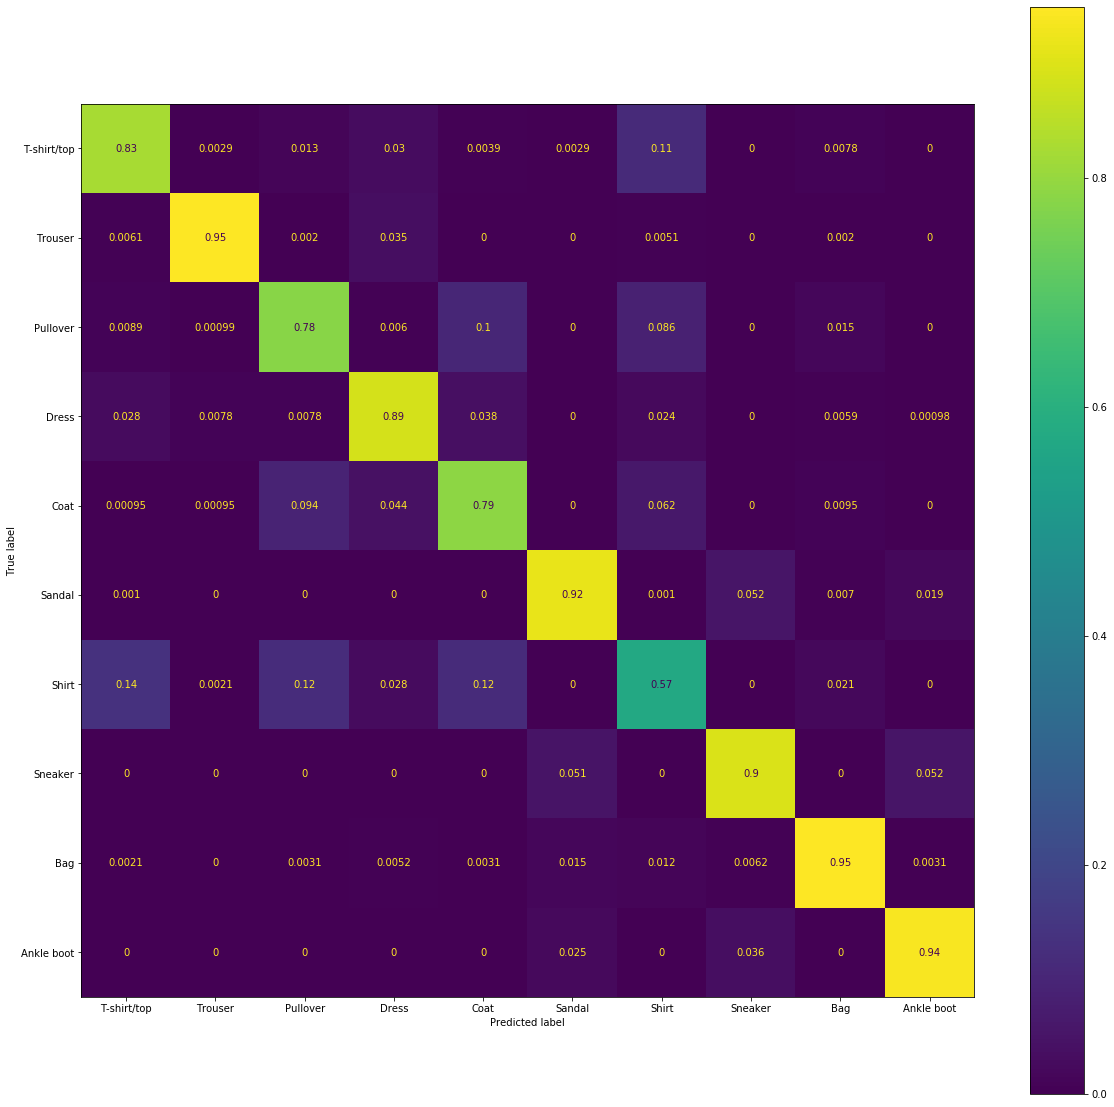

In [56]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(forest, x_valid_pca, y_valid,
                                     normalize='true', 
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown labels in the test set: 

In [ ]:
y_pred_forest=forest.predict(x_test_pca)

In [ ]:
# save that on a .csv file for the submission
predictions_forest_file = y_pred_logreg.to_csv('y_predictions_forest.csv', sep=',',index=False)

# Model - Neural Network

### Pre-processing

### Model estimation

### Model evaluation

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown label in the test set: 

In [ ]:
y_pred_nn=knn.predict(x_test)

# Model - Support Vector Machine

In [ ]:
from sklearn.svm import SVC

### Pre-processing

In [ ]:
#SET SIZE = size of training set to use. Use 50000 to use full TS
size = 10000

#For better numerical stability is advisible to divide by 255
x_train_sc=x_train[0:size]/255
x_valid_sc=x_valid[0:size]/255
x_test_sc =x_test[0:size]/255

y_train_sc=y_train[0:size]
y_valid_sc=y_valid[0:size]

### Model estimation

In [8]:
# Define the grid for the grid search
Cs = np.power(2, np.asarray(list(range(4)))).tolist() # C = regularization parameter
gammas = np.power(1/2, np.asarray(list(range(6)))).tolist()[3:] # gamma: parameter for the RBF kernel

param_grid = [
    {'C': Cs, 'gamma': gammas, 'kernel': ['rbf']},
]

# Cross Validation strategy
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
print(param_grid)

[{'C': [1, 2, 4, 8], 'gamma': [0.125, 0.0625, 0.03125], 'kernel': ['rbf']}]


In [15]:
##################################################
# Implement you model here
##################################################

svc = SVC()
# grid search con 5 fold cross validation
clf = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1)
clf.fit(x_train_sc, y_train)

print(clf.best_params_)
print("Cross Validation Accuracy: %f" % clf.best_score_)

{'C': 4, 'gamma': 0.03125, 'kernel': 'rbf'}
Cross Validation Accuracy: 0.872500


In [17]:
# save the model to disk
filename = 'grid_search_svm_downsampled.sav'
joblib.dump(clf, filename)

['grid_search_svm_downsampled.sav']

In [18]:
clf.best_params_

{'C': 4, 'gamma': 0.03125, 'kernel': 'rbf'}

In [19]:
clf.score(x_valid_sc, y_valid)

0.8781

In [23]:
results_svm_gs = pd.DataFrame(clf.cv_results_)
results_svm_gs.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,237.260946,1.239280,27.493530,0.134380,1,0.125,rbf,"{'C': 1, 'gamma': 0.125, 'kernel': 'rbf'}",0.748503,0.735265,0.741871,0.748374,0.766032,0.7480,0.010245,12
1,128.451676,1.635109,21.844860,0.238880,1,0.0625,rbf,"{'C': 1, 'gamma': 0.0625, 'kernel': 'rbf'}",0.856287,0.838661,0.861431,0.847924,0.864729,0.8538,0.009461,8
2,66.187876,0.774719,18.151979,0.261955,1,0.03125,rbf,"{'C': 1, 'gamma': 0.03125, 'kernel': 'rbf'}",0.866267,0.851648,0.874937,0.863432,0.877255,0.8667,0.009128,4
3,240.696215,0.314167,27.755970,0.341017,2,0.125,rbf,"{'C': 2, 'gamma': 0.125, 'kernel': 'rbf'}",0.761477,0.745255,0.757879,0.764882,0.779559,0.7618,0.011079,9
4,138.407228,0.680498,22.266635,0.117981,2,0.0625,rbf,"{'C': 2, 'gamma': 0.0625, 'kernel': 'rbf'}",0.865269,0.841159,0.868434,0.855928,0.870741,0.8603,0.010822,5


## Train a single model with the best params with all the TS

In [42]:
#load already trained model if available

In [37]:
svm_final = SVC(C=4, gamma=0.03125, kernel='rbf')
svm_final.fit(x_train_sc, y_train)

SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.03125, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Model evaluation

In [38]:
svm_final.score(x_valid_sc, y_valid)

0.9039

In [39]:
# save the model to disk
filename = 'svm_model_fullTS.sav'
joblib.dump(svm_final, filename)

['svm_model_fullTS.sav']

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown label in the test set: 

In [ ]:
y_pred_svm=svm_final.predict(x_test_sc)

In [ ]:
# save that on a .csv file for the submission
predictions_svm_file = y_pred_svm.to_csv('y_predictions_svm.csv', sep=',',index=False)